In [694]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

In [695]:
# Load diabetes dataset
data = pd.read_csv("diabetic_data.csv")

In [696]:
# Data Preprocessing: Decode admission_type_id
admission_type_dict = {
    1: 'Emergency', 2: 'Urgent', 3: 'Elective', 4: 'Newborn',
    5: 'Not Available', 6: np.nan, 7: 'Trauma Center', 8: 'Not Mapped'
}
data['admission_type_id'] = data['admission_type_id'].map(admission_type_dict)

In [697]:
# Data Preprocessing: Decode discharge_disposition_id
discharge_disposition_dict = {
    1: 'Discharged to home',
    2: 'Discharged/transferred to another short term hospital',
    3: 'Discharged/transferred to SNF',
    4: 'Discharged/transferred to ICF',
    5: 'Discharged/transferred to another type of inpatient care institution',
    6: 'Discharged/transferred to home with home health service',
    7: 'Left AMA',
    8: 'Discharged/transferred to home under care of Home IV provider',
    9: 'Admitted as an inpatient to this hospital',
    10: 'Neonate discharged to another hospital for neonatal aftercare',
    11: 'Expired',
    12: 'Still patient or expected to return for outpatient services',
    13: 'Hospice / home',
    14: 'Hospice / medical facility',
    15: 'Discharged/transferred within this institution to Medicare approved swing bed',
    16: 'Discharged/transferred/referred another institution for outpatient services',
    17: 'Discharged/transferred/referred to this institution for outpatient services',
    18: np.nan,
    19: 'Expired at home. Medicaid only, hospice.',
    20: 'Expired in a medical facility. Medicaid only, hospice.',
    21: 'Expired, place unknown. Medicaid only, hospice.',
    22: 'Discharged/transferred to another rehab fac including rehab units of a hospital.',
    23: 'Discharged/transferred to a long term care hospital.',
    24: 'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.',
    25: 'Not Mapped',
    26: 'Unknown/Invalid',
    27: 'Discharged/transferred to a federal health care facility.',
    28: 'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
    29: 'Discharged/transferred to a Critical Access Hospital (CAH).',
    30: 'Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere'
}
data['discharge_disposition_id'] = data['discharge_disposition_id'].map(discharge_disposition_dict)

In [698]:
# Data Preprocessing: Initial cleaning and target mapping

# Decode admission_source_id
admission_source_dict = {
    1: 'Physician Referral', 2: 'Clinic Referral', 3: 'HMO Referral',
    4: 'Transfer from a hospital', 5: 'Transfer from a Skilled Nursing Facility (SNF)',
    6: 'Transfer from another health care facility', 7: 'Emergency Room',
    8: 'Court/Law Enforcement', 9: 'Not Available', 10: 'Transfer from critical access hospital',
    11: 'Normal Delivery', 12: 'Premature Delivery', 13: 'Sick Baby',
    14: 'Extramural Birth', 15: 'Not Available', 17: np.nan,
    18: 'Transfer From Another Home Health Agency', 19: 'Readmission to Same Home Health Agency',
    20: 'Not Mapped', 21: 'Unknown/Invalid',
    22: 'Transfer from hospital inpt/same fac reslt in a sep claim',
    23: 'Born inside this hospital', 24: 'Born outside this hospital',
    25: 'Transfer from Ambulatory Surgery Center', 26: 'Transfer from Hospice'
}
data['admission_source_id'] = data['admission_source_id'].map(admission_source_dict)

# Display decoded categorical fields
print(data[['admission_type_id', 'discharge_disposition_id', 'admission_source_id']])

# Replace '?' with NaN
data.replace('?', np.nan, inplace=True)

# Drop columns with excessive missing values or irrelevant for modeling
data.drop(columns=['weight', 'encounter_id', 'patient_nbr'], inplace=True)

# Map readmitted for binary classification
data['readmitted'] = data['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

       admission_type_id       discharge_disposition_id  \
0                    NaN                     Not Mapped   
1              Emergency             Discharged to home   
2              Emergency             Discharged to home   
3              Emergency             Discharged to home   
4              Emergency             Discharged to home   
...                  ...                            ...   
101761         Emergency  Discharged/transferred to SNF   
101762         Emergency  Discharged/transferred to ICF   
101763         Emergency             Discharged to home   
101764            Urgent  Discharged/transferred to SNF   
101765         Emergency             Discharged to home   

                                   admission_source_id  
0                                   Physician Referral  
1                                       Emergency Room  
2                                       Emergency Room  
3                                       Emergency Room  
4     

In [699]:
# Data Preprocessing: Handle missing values
data.dropna(subset=['diag_1'], inplace=True)
data['race'] = data['race'].fillna(data['race'].mode()[0])
data['A1Cresult'] = data['A1Cresult'].fillna('not measured')
data['max_glu_serum'] = data['max_glu_serum'].fillna('not measured')
data['payer_code'] = data['payer_code'].fillna('unknown')
data['medical_specialty'] = data['medical_specialty'].fillna('unknown')
data['diag_2'] = data['diag_2'].fillna('NO_SECONDARY_DX')
data['diag_3'] = data['diag_3'].fillna('NO_TERTIARY_DX')
data['admission_type_id'] = data['admission_type_id'].fillna('Not Available')
data['discharge_disposition_id'] = data['discharge_disposition_id'].fillna('Not Available')
data['admission_source_id'] = data['admission_source_id'].fillna('Not Available')
payer_data = data[['payer_code', 'readmitted']].copy()


In [700]:
# Check race distribution
print("Race distribution before encoding:")
print(data['race'].value_counts(normalize=True))

Race distribution before encoding:
race
Caucasian          0.770190
AfricanAmerican    0.188717
Hispanic           0.020001
Other              0.014802
Asian              0.006290
Name: proportion, dtype: float64


In [701]:
# Data Preprocessing: Clean invalid data and aggregate medications
data = data[data['gender'].isin(['Male', 'Female'])]
medication_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
                  'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
                  'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
                  'examide', 'citoglipton', 'glyburide-metformin', 'glipizide-metformin',
                  'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

# Store medication data before any preprocessing
med_data = data[medication_cols + ['readmitted']].copy()

# Map readmitted values correctly before any other preprocessing
print("\nOriginal readmitted values:")
print(data['readmitted'].value_counts())

med_data['readmitted'] = data['readmitted']  # Use the binary values

print("\nBinary readmitted values:")
print(data['readmitted'].value_counts())

# Calculate number of medications taken
data['num_medications_taken'] = data[medication_cols].apply(lambda x: (x != 'No').sum(), axis=1)

# Now we can safely drop the medication columns from main data
data.drop(columns=medication_cols, inplace=True)

# Keep insulin column for analysis
insulin_col = ['insulin']


Original readmitted values:
readmitted
0    90390
1    11352
Name: count, dtype: int64

Binary readmitted values:
readmitted
0    90390
1    11352
Name: count, dtype: int64


In [702]:
# Data Preprocessing: Remove outliers
numeric_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
                'num_medications', 'number_outpatient', 'number_emergency',
                'number_inpatient', 'number_diagnoses', 'num_medications_taken']
for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    multiplier = 2.0 if col in ['number_outpatient', 'number_emergency'] else 1.5
    lower = Q1 - multiplier * IQR
    upper = Q3 + multiplier * IQR
    data = data[(data[col] >= lower) & (data[col] <= upper)]

In [703]:
# Data Preprocessing: Encode features and standardize
categorical_cols = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
                    'race', 'gender', 'age', 'payer_code', 'medical_specialty',
                    'A1Cresult', 'max_glu_serum', 'change', 'diabetesMed', 'insulin']
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cats = onehot_encoder.fit_transform(data[categorical_cols])
encoded_df = pd.DataFrame(encoded_cats, columns=onehot_encoder.get_feature_names_out(categorical_cols))
data = data.drop(columns=categorical_cols)
data = pd.concat([data, encoded_df], axis=1)

le = LabelEncoder()
for col in ['diag_1', 'diag_2', 'diag_3']:
    data[col] = le.fit_transform(data[col])

# Standardize only the numeric columns, excluding one-hot encoded columns
scaler = StandardScaler()
# Define numeric columns that are not one-hot encoded
numeric_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
                'num_medications', 'number_outpatient', 'number_emergency',
                'number_inpatient', 'number_diagnoses', 'num_medications_taken']
original_visit_data = data[['number_outpatient', 'number_emergency', 'number_inpatient']].copy()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

print('Null values after preprocessing:\n', data.isnull().sum())
print('\nShape of preprocessed data:', data.shape)
print('\nSummary statistics:\n', data.describe())
print('\nFirst few rows of preprocessed data:\n', data.head())
print('\nSample of encoded categorical columns:\n', data[encoded_df.columns[:5]].head())

Null values after preprocessing:
 time_in_hospital      20843
num_lab_procedures    20843
num_procedures        20843
num_medications       20843
number_outpatient     20843
                      ...  
change_No             20843
diabetesMed_Yes       20843
insulin_No            20843
insulin_Steady        20843
insulin_Up            20843
Length: 170, dtype: int64

Shape of preprocessed data: (85789, 170)

Summary statistics:
        time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count      6.494600e+04        6.494600e+04    6.494600e+04     6.494600e+04   
mean       6.126689e-17       -1.120309e-16    9.715178e-17    -5.951641e-17   
std        1.000008e+00        1.000008e+00    1.000008e+00     1.000008e+00   
min       -1.176738e+00       -2.161890e+00   -7.909161e-01    -2.101020e+00   
25%       -7.919360e-01       -5.955754e-01   -7.909161e-01    -6.859043e-01   
50%       -4.071336e-01        8.316086e-02   -6.179137e-02    -5.696400e-02   
75%     

In [704]:
# Check race distribution after encoding
print("Race distribution after encoding:")
race_cols = [col for col in data.columns if col.startswith('race_')]
race_distribution = data[race_cols].sum() / len(data)
print(race_distribution)

Race distribution after encoding:
race_Asian        0.005479
race_Caucasian    0.574584
race_Hispanic     0.016063
race_Other        0.011435
dtype: float64


In [705]:
# Remove rows with missing primary diagnosis (critical field)
data.dropna(subset=['diag_1'], inplace=True)

In [706]:

# Verify all nulls are handled
print(data.isnull().sum())


time_in_hospital      20843
num_lab_procedures    20843
num_procedures        20843
num_medications       20843
number_outpatient     20843
                      ...  
change_No             20843
diabetesMed_Yes       20843
insulin_No            20843
insulin_Steady        20843
insulin_Up            20843
Length: 170, dtype: int64


In [707]:
data.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,...,A1Cresult_Norm,A1Cresult_not measured,max_glu_serum_>300,max_glu_serum_Norm,max_glu_serum_not measured,change_No,diabetesMed_Yes,insulin_No,insulin_Steady,insulin_Up
1,-0.407134,0.866318,-0.790916,0.571976,0.0,0.0,-0.536941,138,72,108,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,-0.791936,0.083161,-0.061791,0.257506,0.0,0.0,-0.536941,541,89,233,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,-1.176738,0.448634,-0.790916,-1.000374,0.0,0.0,-0.536941,51,20,73,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
6,-0.022331,1.440633,-0.061791,1.043681,0.0,0.0,-0.536941,256,233,730,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
7,0.362471,1.597265,-0.790916,-0.371434,0.0,0.0,-0.536941,269,298,73,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


# Key Findings from Exploratory Data Analysis

### Readmission percentage

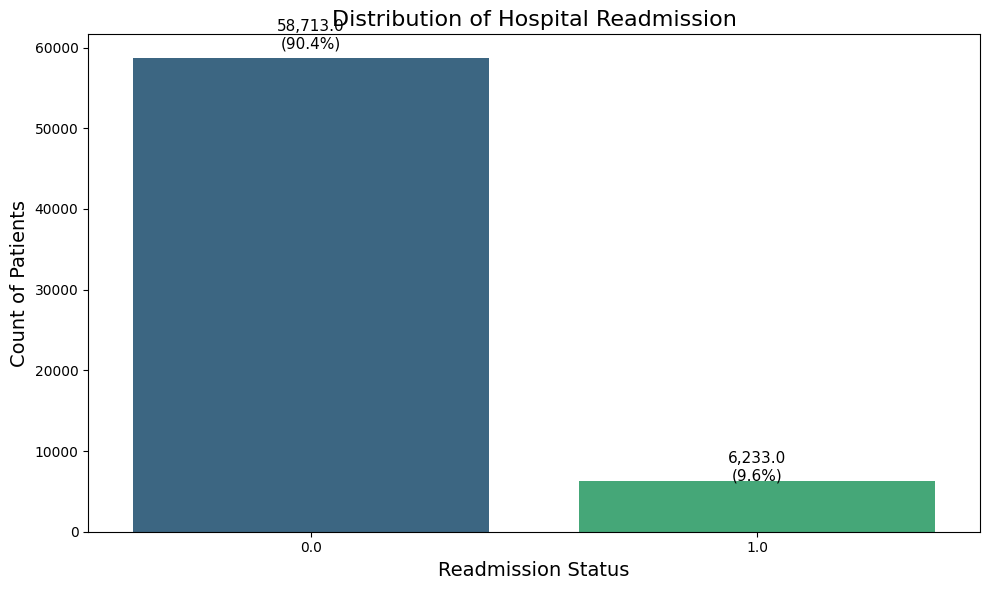

In [708]:
data['readmitted_binary'] = (data['readmitted'] == '<30').astype(int)

# Analyzing the target variable 'readmitted'
readmitted_counts = data['readmitted'].value_counts()
readmitted_percent = (data['readmitted'].value_counts(normalize=True) * 100).round(2)
readmission_summary = pd.DataFrame({
    'Count': readmitted_counts,
    'Percentage (%)': readmitted_percent
})


# visual representation
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='readmitted', data=data, hue='readmitted', palette='viridis', legend=False)
# Adding count and percentage labels to the bars
for i, p in enumerate(ax.patches):
    height = p.get_height()
    percentage = readmitted_percent.iloc[i] if i < len(readmitted_percent) else 0
    ax.annotate(f"{height:,}\n({percentage}%)",
                (p.get_x() + p.get_width() / 2., height * 1.02),
                ha='center', va='baseline', fontsize=11)

plt.title('Distribution of Hospital Readmission', fontsize=16)
plt.xlabel('Readmission Status', fontsize=14)
plt.ylabel('Count of Patients', fontsize=14)
plt.tight_layout()
plt.show()



### Admission type with regards to readmission column  

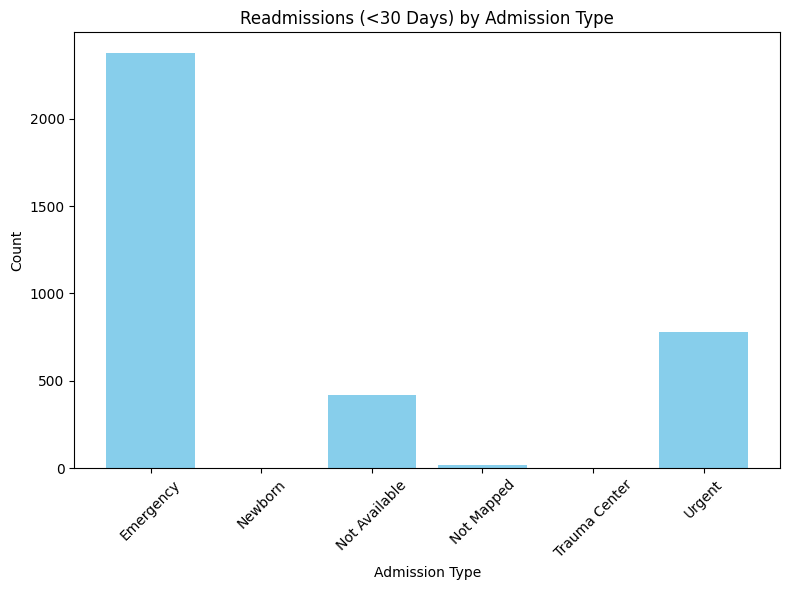

In [709]:
# Filter for readmissions (readmitted == 1, which corresponds to <30 days)
anytarget = data[data["readmitted"] == 1]

# Identify one-hot encoded columns for admission_type_id
admission_cols = [col for col in data.columns if col.startswith('admission_type_id_')]
count_by_admission = {}

for col in admission_cols:
    admission_type = col.replace('admission_type_id_', '')
    count_by_admission[admission_type] = anytarget[col].sum()

# Convert to a Series for plotting
count_series = pd.Series(count_by_admission)

# Plot
plt.figure(figsize=(8, 6))
plt.bar(count_series.index.astype(str), count_series.values, color='skyblue')
plt.xlabel('Admission Type')
plt.ylabel('Count')
plt.title('Readmissions (<30 Days) by Admission Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Number of rows with readmitted == 0: 58713


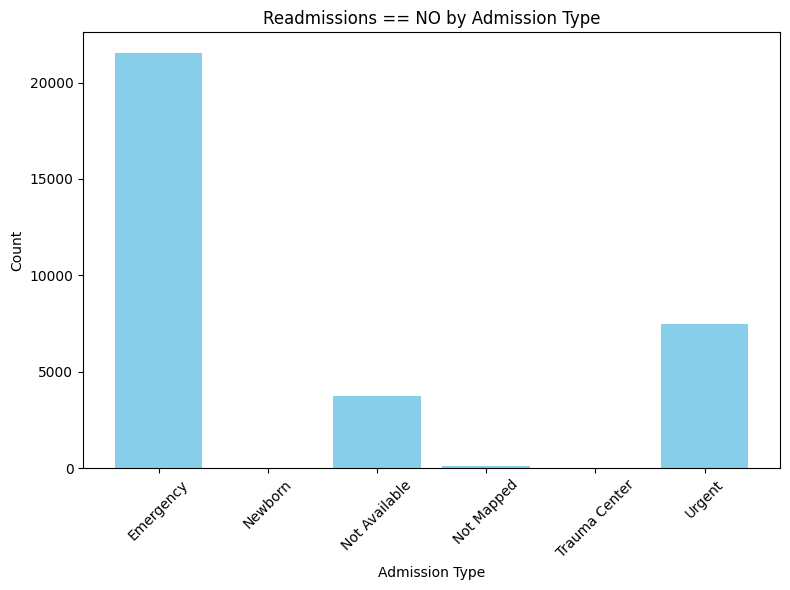

Counts by admission type: {'Emergency': np.int64(21526), 'Newborn': np.int64(6), 'Not Available': np.int64(3719), 'Not Mapped': np.int64(128), 'Trauma Center': np.int64(7), 'Urgent': np.int64(7479)}


In [710]:
# Check the number of rows with readmitted == 0
print("Number of rows with readmitted == 0:", len(data[data["readmitted"] == 0]))

notarget = data[data["readmitted"] == 0]
admission_cols = [col for col in data.columns if col.startswith('admission_type_id_')]

# Create a dictionary to store counts for each admission type
count_by_admission = {}

# Sum the one-hot encoded columns for the filtered data to get counts
for col in admission_cols:
    admission_type = col.replace('admission_type_id_', '')
    # Convert standardized values back to binary (0 or 1) using a threshold (e.g., 0)
    binary_values = (notarget[col] > 0).astype(int)
    count_by_admission[admission_type] = binary_values.sum()

# Convert to a Series for plotting
count_series = pd.Series(count_by_admission)

# Plot
plt.figure(figsize=(8, 6))
plt.bar(count_series.index.astype(str), count_series.values, color='skyblue')
plt.xlabel('Admission Type')
plt.ylabel('Count')
plt.title('Readmissions == NO by Admission Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the counts for debugging
print("Counts by admission type:", count_by_admission)

### Age ranges of patients

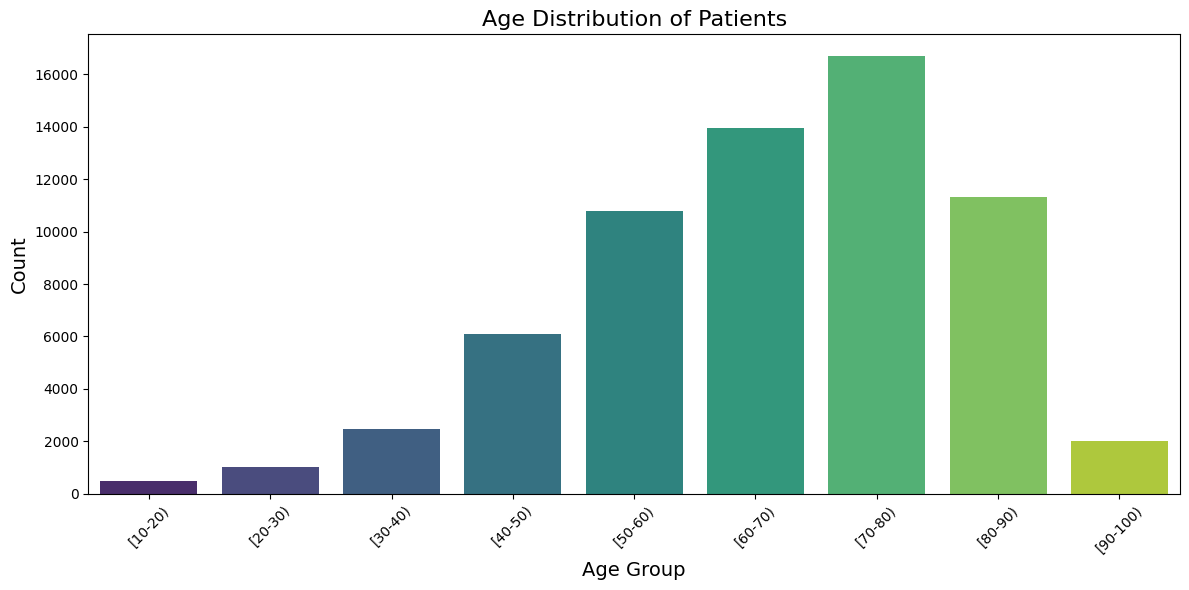

Age group counts: {'[10-20)': np.int64(476), '[20-30)': np.int64(1010), '[30-40)': np.int64(2448), '[40-50)': np.int64(6099), '[50-60)': np.int64(10791), '[60-70)': np.int64(13972), '[70-80)': np.int64(16697), '[80-90)': np.int64(11324), '[90-100)': np.int64(2019)}


In [711]:
# Identify one-hot encoded columns for age
age_cols = [col for col in data.columns if col.startswith('age_')]

# Create a dictionary to store counts for each age group
age_counts = {}

for col in age_cols:
    age_group = col.replace('age_', '')
    binary_values = (data[col] > 0).astype(int)
    age_counts[age_group] = binary_values.sum()

# Convert to a Series for plotting, and sort by age group
age_counts_series = pd.Series(age_counts)
# Sort by age group
age_counts_series = age_counts_series.sort_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=age_counts_series.index, y=age_counts_series.values, hue=age_counts_series.index, palette='viridis', legend=False)
plt.title('Age Distribution of Patients', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the counts for debugging
print("Age group counts:", age_counts)

### Gender of patients

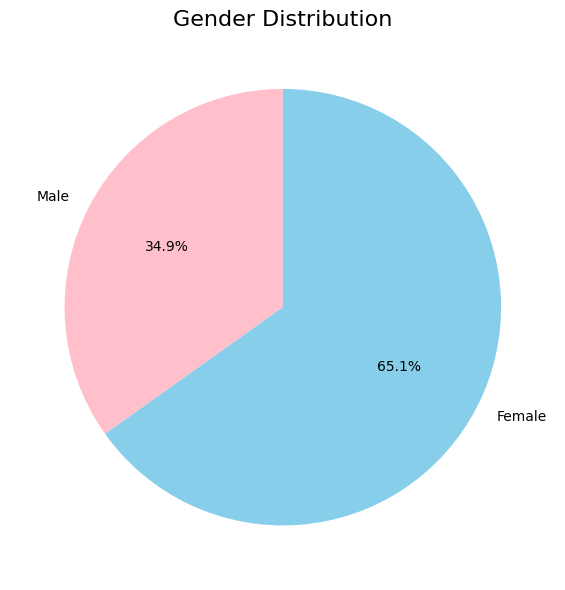

Gender counts: {'Male': np.float64(29905.0), 'Female': np.float64(55884.0)}


In [712]:
# Identify one-hot encoded columns for gender
gender_cols = [col for col in data.columns if col.startswith('gender_')]
gender_counts = {}

# Sum the one-hot encoded columns to get counts for each gender category
for col in gender_cols:
    gender_category = col.replace('gender_', '')
    gender_counts[gender_category] = data[col].sum()

# Infer the count for the dropped category
total_rows = len(data)
if 'Female' in gender_counts:
    gender_counts['Male'] = total_rows - gender_counts['Female']
elif 'Male' in gender_counts:
    gender_counts['Female'] = total_rows - gender_counts['Male']

# Convert to a Series for plotting
gender_counts_series = pd.Series(gender_counts)

# Plot
plt.figure(figsize=(10, 6))
plt.pie(gender_counts_series, labels=gender_counts_series.index, autopct='%1.1f%%',
        startangle=90, colors=['skyblue', 'pink', 'lightgreen'][:len(gender_counts_series)])
plt.title('Gender Distribution', fontsize=16)
plt.tight_layout()
plt.show()

# Print the counts for debugging
print("Gender counts:", gender_counts)

### Race of patients

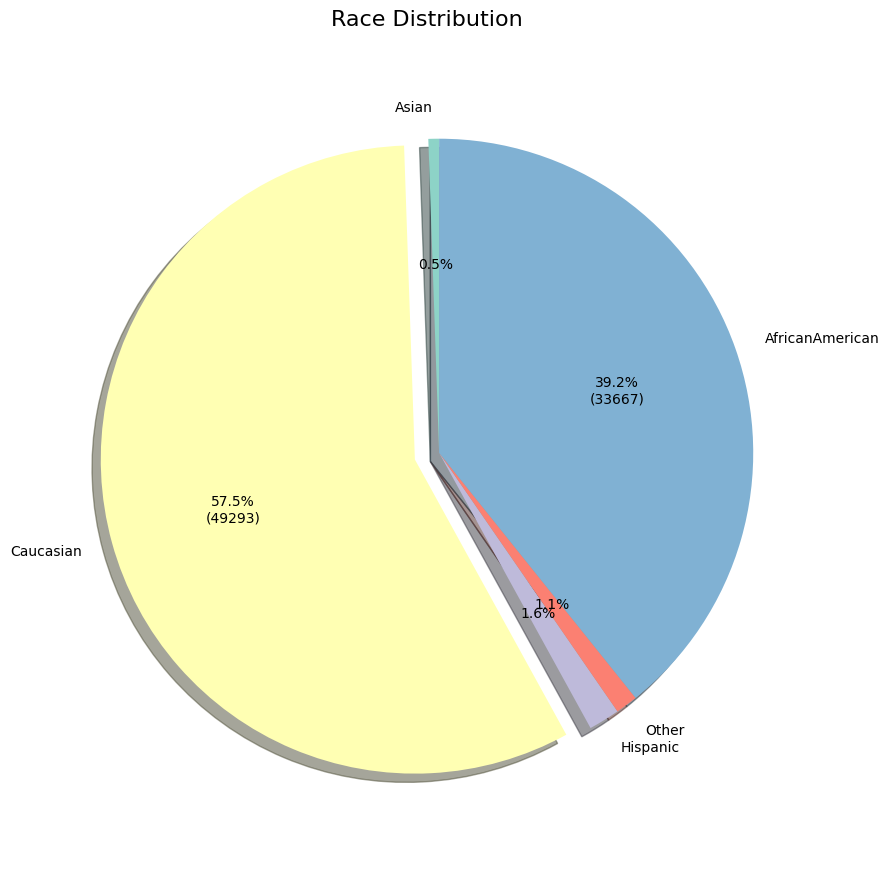

Race counts: {'Asian': np.float64(470.0), 'Caucasian': np.float64(49293.0), 'Hispanic': np.float64(1378.0), 'Other': np.float64(981.0), 'AfricanAmerican': np.float64(33667.0)}


In [713]:

# Identify one-hot encoded columns for race
race_cols = [col for col in data.columns if col.startswith('race_')]

# Count each race
race_counts = {}
for col in race_cols:
    race_category = col.replace('race_', '')
    race_counts[race_category] = data[col].sum()

# Infer the dropped category (e.g., 'AfricanAmerican')
total_rows = len(data)
sum_encoded_races = sum(race_counts.values())
race_counts['AfricanAmerican'] = total_rows - sum_encoded_races

race_counts_series = pd.Series(race_counts)

# Identify the index of the largest category
max_index = race_counts_series.values.argmax()

# Set explode: only largest slice gets exploded
explode = [0.08 if i == max_index else 0 for i in range(len(race_counts_series))]

# Format function: skip showing absolute if the slice is too small
def format_autopct(pct, allvals):
    total = sum(allvals)
    absolute = int(round(pct/100.*total))
    if pct < 2:
        return f"{pct:.1f}%"
    return f"{pct:.1f}%\n({absolute})"

# Plot
plt.figure(figsize=(9, 9))
plt.pie(race_counts_series,
        labels=race_counts_series.index,
        autopct=lambda pct: format_autopct(pct, race_counts_series.values),
        startangle=90,
        explode=explode,
        colors=sns.color_palette('Set3', len(race_counts_series)),
        shadow=True)

plt.title('Race Distribution', fontsize=16)
plt.axis('equal')  # Keep pie as a circle
plt.tight_layout()
plt.show()

# Debug print
print("Race counts:", race_counts)

### Readmission based on the number of stay days

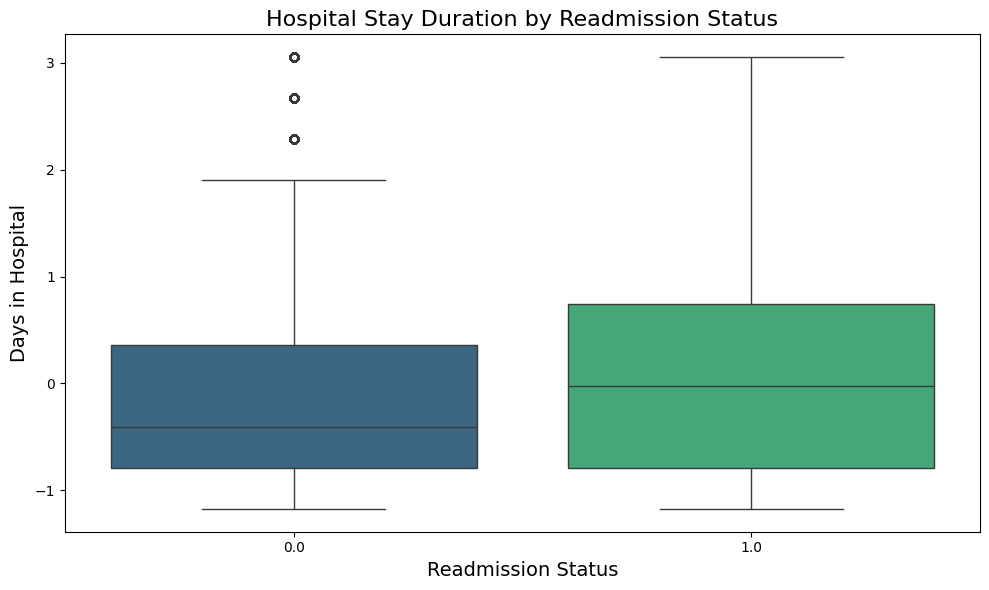

In [714]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='readmitted', y='time_in_hospital',hue="readmitted" ,data=data, palette='viridis', legend= False)
plt.title('Hospital Stay Duration by Readmission Status', fontsize=16)
plt.xlabel('Readmission Status', fontsize=14)
plt.ylabel('Days in Hospital', fontsize=14)
plt.tight_layout()
plt.show()

### Admission types in the hospital

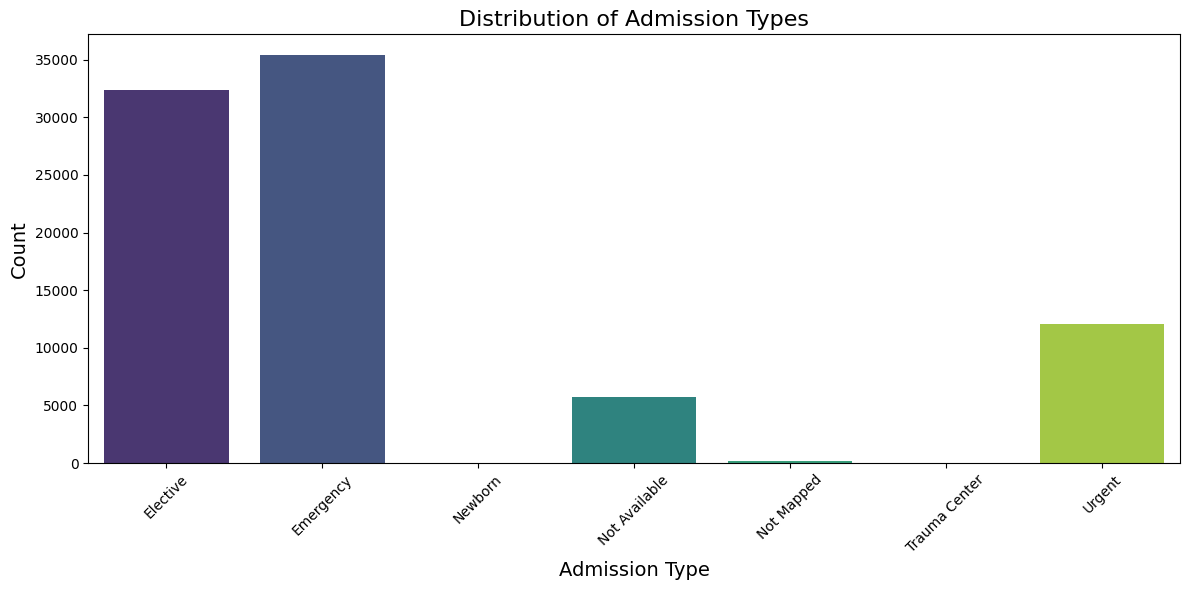

Admission type counts: {'Emergency': np.float64(35422.0), 'Newborn': np.float64(8.0), 'Not Available': np.float64(5727.0), 'Not Mapped': np.float64(207.0), 'Trauma Center': np.float64(15.0), 'Urgent': np.float64(12038.0), 'Elective': np.float64(32372.0)}


In [715]:
# Identify one-hot encoded columns for admission_type_id
admission_cols = [col for col in data.columns if col.startswith('admission_type_id_')]

# Create a dictionary to store counts for each admission type
admission_counts = {}

# Sum the one-hot encoded columns to get counts for each admission type
for col in admission_cols:
    admission_type = col.replace('admission_type_id_', '')  # Extract admission type name (e.g., 'Emergency')
    admission_counts[admission_type] = data[col].sum()

# Infer the count for the dropped category (e.g., 'Elective')
total_rows = len(data)
sum_encoded_admissions = sum(admission_counts.values())
admission_counts['Elective'] = total_rows - sum_encoded_admissions

# Convert to a Series for plotting
admission_counts_series = pd.Series(admission_counts)

# Sort for consistency (optional, based on preference)
admission_counts_series = admission_counts_series.sort_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=admission_counts_series.index, y=admission_counts_series.values, hue=admission_counts_series.index, palette='viridis', legend=False)
plt.title('Distribution of Admission Types', fontsize=16)
plt.xlabel('Admission Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the counts for debugging
print("Admission type counts:", admission_counts)

### Admission types distribution that get readmitted in less than 30 days


In [716]:
# function to calculate readmission rates by category
def calculate_readmission_rate(df, feature):
    """Calculate readmission rates for each category of a feature"""
    # Counting occurrences for each combination of feature and readmission status
    grouped = df.groupby([feature, 'readmitted']).size().unstack(fill_value=0)

    # Calculating total count for each category
    grouped['total'] = grouped.sum(axis=1)

    # Calculating readmission rates
    grouped['<30_days_rate'] = (grouped['<30'] / grouped['total'] * 100).round(2)
    grouped['>30_days_rate'] = (grouped['>30'] / grouped['total'] * 100).round(2)
    grouped['total_readmission_rate'] = ((grouped['<30'] + grouped['>30']) / grouped['total'] * 100).round(2)

    # rates and counts
    return grouped[['<30_days_rate', '>30_days_rate', 'total_readmission_rate', 'total']]

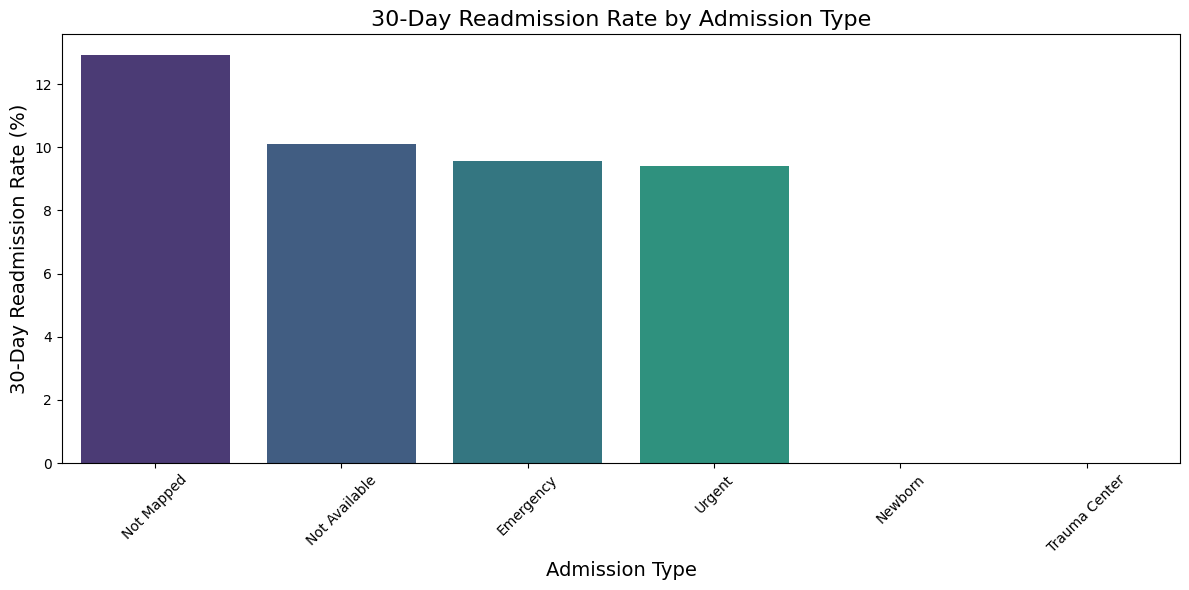

Readmission rates by admission type:
                               <30_days_rate
admission_type_reconstructed               
Not Mapped                            12.93
Not Available                         10.10
Emergency                              9.58
Urgent                                 9.42
Newborn                                0.00
Trauma Center                          0.00


In [717]:
# Identify one-hot encoded columns for admission_type_id
admission_cols = [col for col in data.columns if col.startswith('admission_type_id_')]

# Convert standardized values back to binary (0 or 1) using a threshold (e.g., 0)
binary_data = data[admission_cols].apply(lambda x: (x > 0).astype(int))
data['admission_type_reconstructed'] = binary_data.idxmax(axis=1).str.replace('admission_type_id_', '')

# Calculate readmission rate for each admission type
def calculate_readmission_rate(df, group_col):
    # Group by the specified column and calculate the rate
    grouped = df.groupby(group_col)
    readmission_rates = pd.DataFrame({
        '<30_days_rate': (grouped['readmitted'].mean() * 100).round(2)  # Convert to percentage
    })
    return readmission_rates

# Calculate readmission rate using the reconstructed admission type
valid_admission = data.dropna(subset=['admission_type_reconstructed', 'readmitted'])  # Drop rows with missing values in key columns
admission_readmission = calculate_readmission_rate(valid_admission, 'admission_type_reconstructed')
admission_readmission = admission_readmission.sort_values('<30_days_rate', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=admission_readmission.index, y=admission_readmission['<30_days_rate'], hue=admission_readmission.index, palette='viridis', legend=False)
plt.title('30-Day Readmission Rate by Admission Type', fontsize=16)
plt.xlabel('Admission Type', fontsize=14)
plt.ylabel('30-Day Readmission Rate (%)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the results for debugging
print("Readmission rates by admission type:\n", admission_readmission)

### Readmission rates by admission source


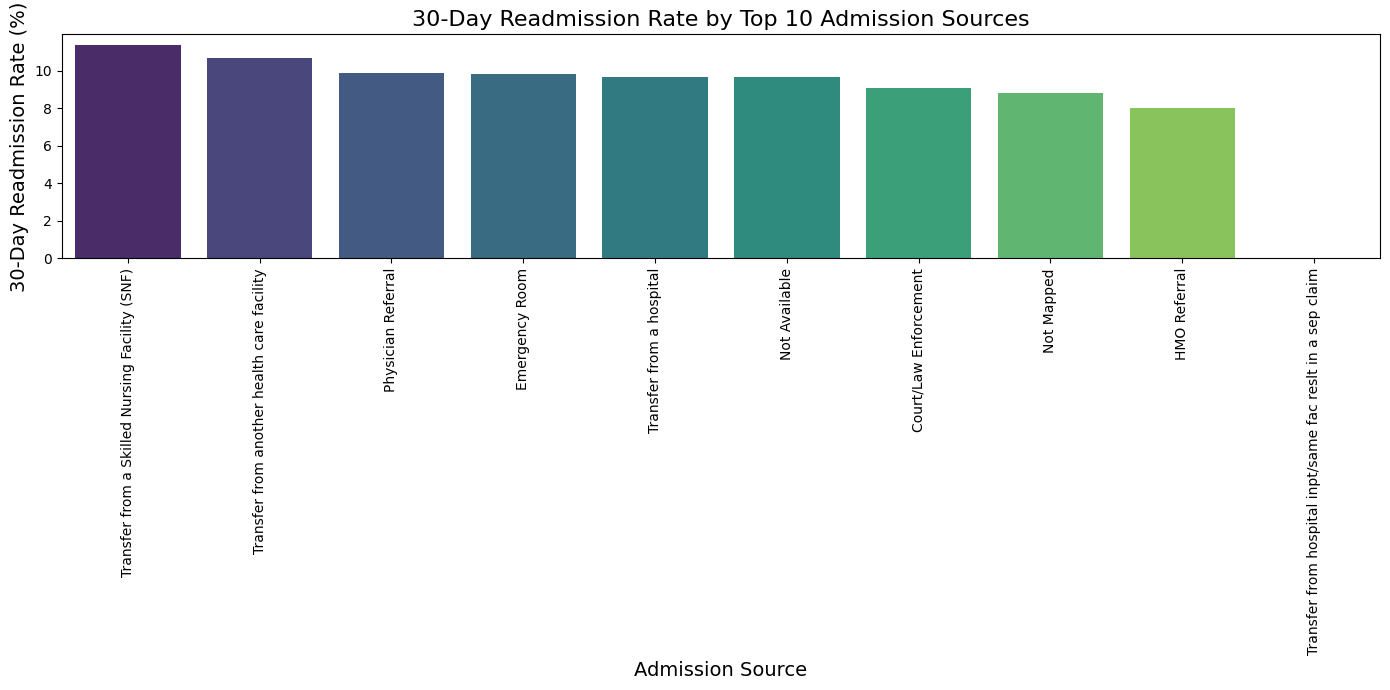

Readmission rates by admission source:
                                                     <30_days_rate
admission_source_reconstructed                                   
Transfer from a Skilled Nursing Facility (SNF)              11.37
Transfer from another health care facility                  10.69
Physician Referral                                           9.87
Emergency Room                                               9.81
Transfer from a hospital                                     9.68
Not Available                                                9.64
Court/Law Enforcement                                        9.08
Not Mapped                                                   8.79
HMO Referral                                                 8.00
Transfer from hospital inpt/same fac reslt in a...           0.00
Number of rows in source_data: 85778
Value counts of readmitted: readmitted
0.0    58707
1.0     6232
Name: count, dtype: int64


In [718]:
# Identify one-hot encoded columns for admission_source_id
source_cols = [col for col in data.columns if col.startswith('admission_source_id_')]

# Convert standardized values back to binary (0 or 1) using a threshold
binary_data = data[source_cols].apply(lambda x: (x > 0).astype(int))
data['admission_source_reconstructed'] = binary_data.idxmax(axis=1).str.replace('admission_source_id_', '')

# Get the top 10 admission sources based on frequency
top_sources = data['admission_source_reconstructed'].value_counts().nlargest(10).index

# Filter data for top 10 admission sources
source_data = data[data['admission_source_reconstructed'].isin(top_sources)]

# Calculate readmission rate (assuming the same function as before)
def calculate_readmission_rate(df, group_col):
    grouped = df.groupby(group_col)
    readmission_rates = pd.DataFrame({
        '<30_days_rate': (grouped['readmitted'].mean() * 100).round(2)
    })
    return readmission_rates

# Calculate readmission rate for top 10 admission sources
source_readmission = calculate_readmission_rate(source_data, 'admission_source_reconstructed')
source_readmission = source_readmission.sort_values('<30_days_rate', ascending=False)

# Plot
plt.figure(figsize=(14, 7))
sns.barplot(x=source_readmission.index, y=source_readmission['<30_days_rate'], hue=source_readmission.index, palette='viridis', legend=False)
plt.title('30-Day Readmission Rate by Top 10 Admission Sources', fontsize=16)
plt.xlabel('Admission Source', fontsize=14)
plt.ylabel('30-Day Readmission Rate (%)', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Debug output
print("Readmission rates by admission source:\n", source_readmission)
print("Number of rows in source_data:", len(source_data))
print("Value counts of readmitted:", source_data['readmitted'].value_counts())

### Seeing the relation between the diagnosis 1 with the readmission before 30 days

In [719]:
def categorize_diagnosis(code):
    if pd.isna(code):
        return "Unknown"

    code = str(code).strip()

    # Check if it's a numeric ICD code
    if code.replace(".", "").isdigit():
        code = float(code)  # Convert to float
        if 1 <= code <= 139:
            return "Infectious Diseases"
        elif 140 <= code <= 239:
            return "Cancer & Neoplasms"
        elif 240 <= code <= 279:
            return "Endocrine Disorders"
        elif 280 <= code <= 289:
            return "Blood Disorders"
        elif 290 <= code <= 319:
            return "Mental Health Disorders"
        elif 320 <= code <= 389:
            return "Nervous System Diseases"
        elif 390 <= code <= 459:
            return "Heart & Circulatory Conditions"
        elif 460 <= code <= 519:
            return "Respiratory Diseases"
        elif 520 <= code <= 579:
            return "Digestive System Diseases"
        elif 580 <= code <= 629:
            return "Kidney & Urinary Disorders"
        elif 630 <= code <= 679:
            return "Pregnancy-Related Conditions"
        elif 680 <= code <= 709:
            return "Skin Disorders"
        elif 710 <= code <= 739:
            return "Muscle & Bone Conditions"
        elif 740 <= code <= 759:
            return "Congenital Disorders"
        elif 760 <= code <= 779:
            return "Perinatal Conditions"
        elif 780 <= code <= 799:
            return "Symptoms & Non-Specific Conditions"
        elif 800 <= code <= 999:
            return "Injuries & Poisoning"
        else:
            return "Unknown ICD Code"

    # If it's an alphanumeric V, W, X, or Y code
    elif code.startswith("V"):
        return "External Injury (Vehicle-related)"
    elif code.startswith("W"):
        return "External Injury (Falls, Accidents)"
    elif code.startswith("X"):
        return "External Injury (Poisoning, Assault)"
    elif code.startswith("Y"):
        return "External Injury (Other Causes)"
    else:
        return "Unknown"

# Apply function to the dataset
data["diag_category"] = data["diag_1"].apply(categorize_diagnosis)

<ipython-input-720-490fcab2f4e2>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=diag_readmission.index, y=diag_readmission['<30_days_rate'], palette='viridis', legend=False)


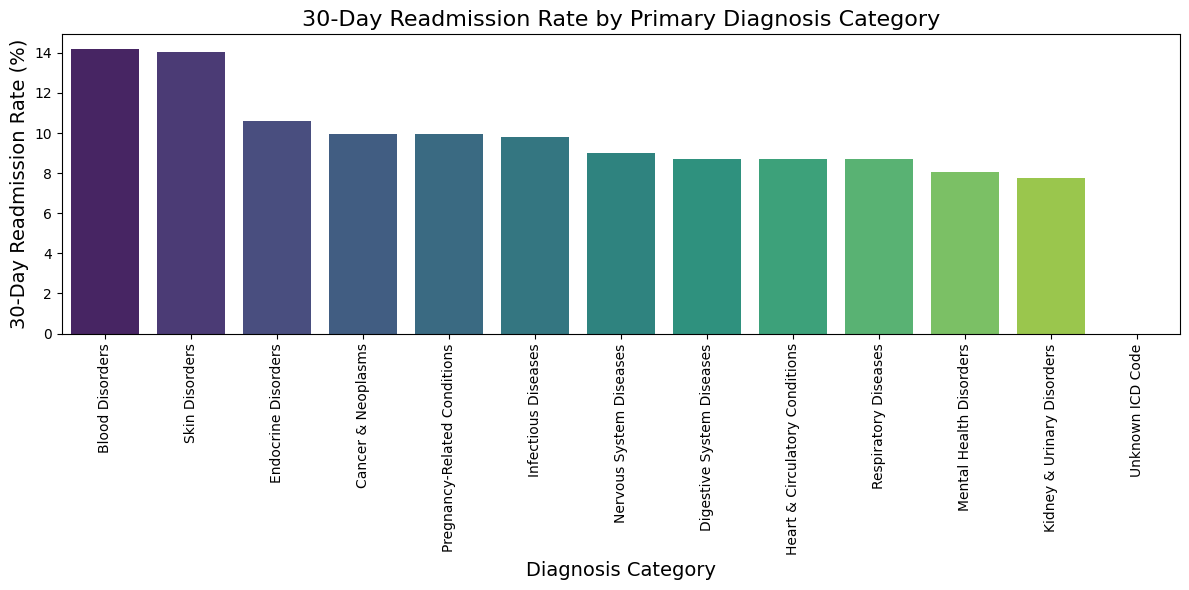

In [720]:
# Calculating readmission rates by primary diagnosis category
diag_readmission = calculate_readmission_rate(data, 'diag_category')
diag_readmission = diag_readmission.sort_values('<30_days_rate', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=diag_readmission.index, y=diag_readmission['<30_days_rate'], palette='viridis', legend=False)
plt.title('30-Day Readmission Rate by Primary Diagnosis Category', fontsize=16)
plt.xlabel('Diagnosis Category', fontsize=14)
plt.ylabel('30-Day Readmission Rate (%)', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Seeing relation between number of diagnosises and the readmission

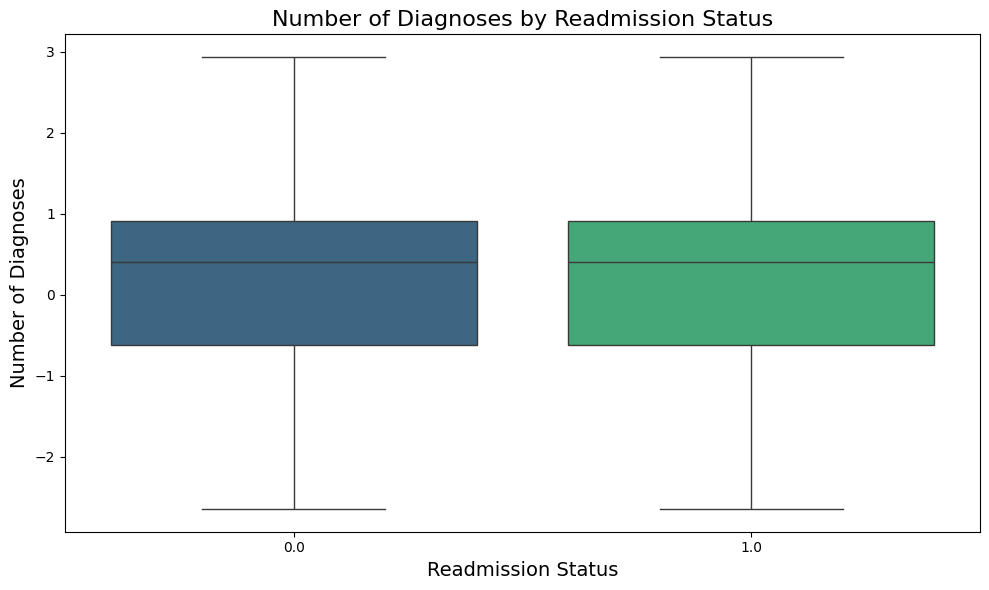

In [721]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='readmitted', y='number_diagnoses', data=data,hue="readmitted", palette='viridis', legend= False)
plt.title('Number of Diagnoses by Readmission Status', fontsize=16)
plt.xlabel('Readmission Status', fontsize=14)
plt.ylabel('Number of Diagnoses', fontsize=14)
plt.tight_layout()
plt.show()

### Seeing the relation between A1C and readmission

Readmission rates by A1Cresult:
                          <30_days_rate
A1Cresult_reconstructed               
Norm                             11.03
>8                                9.24


<ipython-input-722-5085cea936ec>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='A1Cresult_reconstructed', data=filtered_df, palette='viridis')


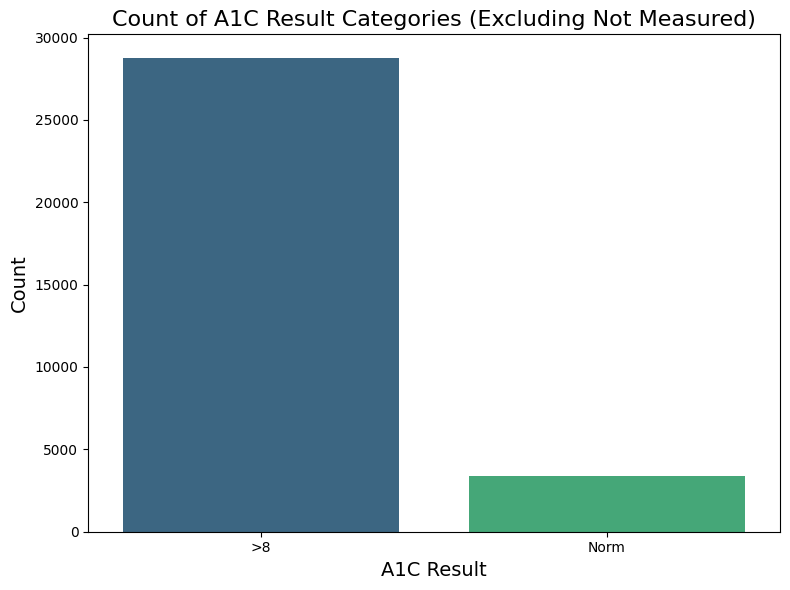

Number of rows in filtered_df: 32142
Value counts of A1Cresult_reconstructed: A1Cresult_reconstructed
>8      28757
Norm     3385
Name: count, dtype: int64
Value counts of readmitted: readmitted
0.0    25862
1.0     2677
Name: count, dtype: int64


In [722]:
# Identify one-hot encoded columns for A1Cresult
a1c_cols = [col for col in data.columns if col.startswith('A1Cresult_')]

# Convert standardized values back to binary (0 or 1) using a threshold
binary_data = data[a1c_cols].apply(lambda x: (x > 0).astype(int))
data['A1Cresult_reconstructed'] = binary_data.idxmax(axis=1).str.replace('A1Cresult_', '')
filtered_df = data[data['A1Cresult_reconstructed'] != 'not measured']

# Calculate readmission rate (assuming the same function as before)
def calculate_readmission_rate(df, group_col):
    grouped = df.groupby(group_col)
    readmission_rates = pd.DataFrame({
        '<30_days_rate': (grouped['readmitted'].mean() * 100).round(2)
    })
    return readmission_rates

# Calculate readmission rate for A1Cresult categories
a1c_readmission = calculate_readmission_rate(filtered_df, 'A1Cresult_reconstructed')
a1c_readmission = a1c_readmission.sort_values('<30_days_rate', ascending=False)

# Print readmission rates for debugging
print("Readmission rates by A1Cresult:\n", a1c_readmission)

# Create count plot
plt.figure(figsize=(8, 6))
sns.countplot(x='A1Cresult_reconstructed', data=filtered_df, palette='viridis')
plt.xticks(rotation=0)
plt.title('Count of A1C Result Categories (Excluding Not Measured)', fontsize=16)
plt.xlabel('A1C Result', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.tight_layout()
plt.show()

# Debug output
print("Number of rows in filtered_df:", len(filtered_df))
print("Value counts of A1Cresult_reconstructed:", filtered_df['A1Cresult_reconstructed'].value_counts())
print("Value counts of readmitted:", filtered_df['readmitted'].value_counts())

### Seeing the relation between the glucose serum results and readmission

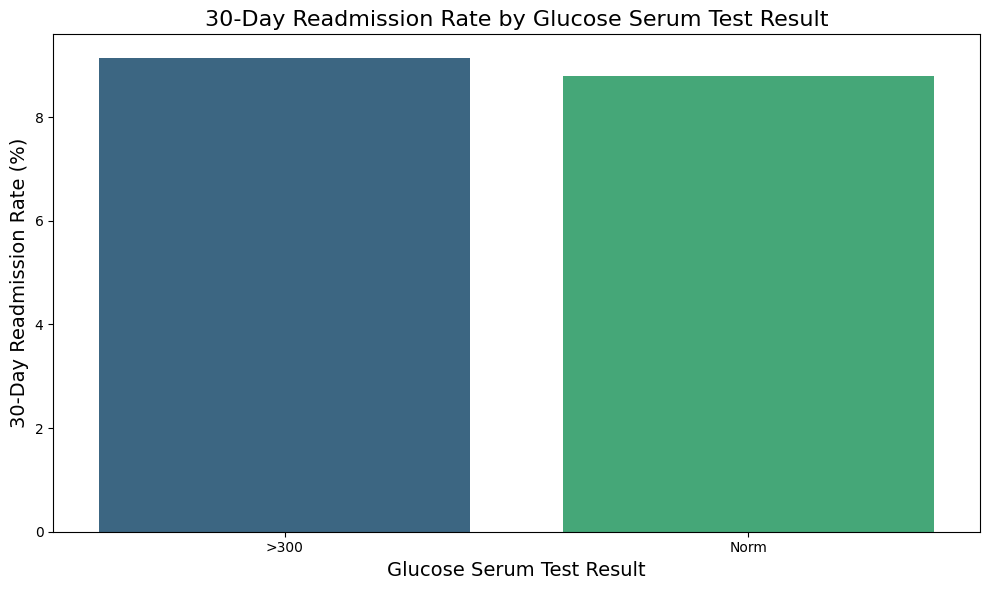

Readmission rates by max_glu_serum:
                              <30_days_rate
max_glu_serum_reconstructed               
>300                                  9.14
Norm                                  8.79
Number of rows in filtered_df: 23680
Value counts of max_glu_serum_reconstructed: max_glu_serum_reconstructed
>300    22265
Norm     1415
Name: count, dtype: int64
Value counts of readmitted: readmitted
0.0    20777
1.0     2086
Name: count, dtype: int64


In [723]:
# Identify one-hot encoded columns for max_glu_serum
glu_cols = [col for col in data.columns if col.startswith('max_glu_serum_')]

# Convert standardized values back to binary (0 or 1) using a threshold
binary_data = data[glu_cols].apply(lambda x: (x > 0).astype(int))
data['max_glu_serum_reconstructed'] = binary_data.idxmax(axis=1).str.replace('max_glu_serum_', '')
filtered_df = data[data['max_glu_serum_reconstructed'] != 'not measured']

# Calculate readmission rate (assuming the same function as before)
def calculate_readmission_rate(df, group_col):
    grouped = df.groupby(group_col)
    readmission_rates = pd.DataFrame({
        '<30_days_rate': (grouped['readmitted'].mean() * 100).round(2)
    })
    return readmission_rates

# Calculate readmission rate for max_glu_serum categories
glu_readmission = calculate_readmission_rate(filtered_df, 'max_glu_serum_reconstructed')
glu_readmission = glu_readmission.sort_values('<30_days_rate', ascending=False)

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=glu_readmission.index, y=glu_readmission['<30_days_rate'], hue=glu_readmission.index, palette='viridis', legend=False)
plt.title('30-Day Readmission Rate by Glucose Serum Test Result', fontsize=16)
plt.xlabel('Glucose Serum Test Result', fontsize=14)
plt.ylabel('30-Day Readmission Rate (%)', fontsize=14)
plt.tight_layout()
plt.show()

# Debug output
print("Readmission rates by max_glu_serum:\n", glu_readmission)
print("Number of rows in filtered_df:", len(filtered_df))
print("Value counts of max_glu_serum_reconstructed:", filtered_df['max_glu_serum_reconstructed'].value_counts())
print("Value counts of readmitted:", filtered_df['readmitted'].value_counts())

### Seeing the effect of using a diabetes medication on readmission

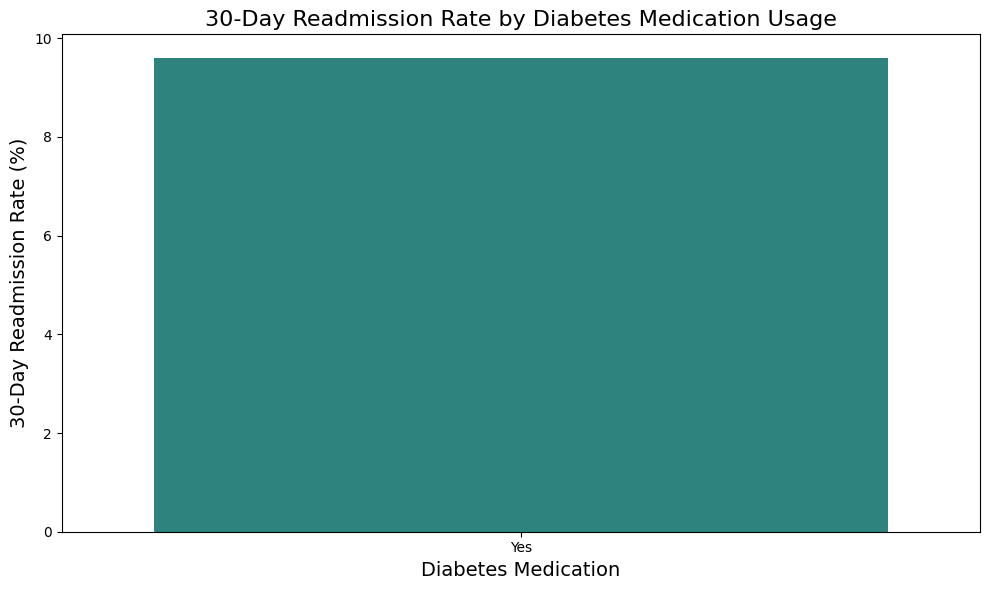

Readmission rates by diabetesMed:
                            <30_days_rate
diabetesMed_reconstructed               
Yes                                  9.6
Number of rows in data: 85789
Value counts of diabetesMed_reconstructed: diabetesMed_reconstructed
Yes    85789
Name: count, dtype: int64
Value counts of readmitted: readmitted
0.0    58713
1.0     6233
Name: count, dtype: int64


In [724]:
# Identify one-hot encoded columns for diabetesMed
diabetes_cols = [col for col in data.columns if col.startswith('diabetesMed_')]

# Convert standardized values back to binary (0 or 1) using a threshold
binary_data = data[diabetes_cols].apply(lambda x: (x > 0).astype(int))
data['diabetesMed_reconstructed'] = binary_data.idxmax(axis=1).str.replace('diabetesMed_', '')

# Calculate readmission rate (assuming the same function as before)
def calculate_readmission_rate(df, group_col):
    grouped = df.groupby(group_col)
    readmission_rates = pd.DataFrame({
        '<30_days_rate': (grouped['readmitted'].mean() * 100).round(2)
    })
    return readmission_rates

# Calculate readmission rate for diabetesMed categories
diabetes_med_readmission = calculate_readmission_rate(data, 'diabetesMed_reconstructed')
diabetes_med_readmission = diabetes_med_readmission.sort_values('<30_days_rate', ascending=False)

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=diabetes_med_readmission.index, y=diabetes_med_readmission['<30_days_rate'],
            hue=diabetes_med_readmission.index, palette='viridis', legend=False)
plt.title('30-Day Readmission Rate by Diabetes Medication Usage', fontsize=16)
plt.xlabel('Diabetes Medication', fontsize=14)
plt.ylabel('30-Day Readmission Rate (%)', fontsize=14)
plt.tight_layout()
plt.show()

# Debug output
print("Readmission rates by diabetesMed:\n", diabetes_med_readmission)
print("Number of rows in data:", len(data))
print("Value counts of diabetesMed_reconstructed:", data['diabetesMed_reconstructed'].value_counts())
print("Value counts of readmitted:", data['readmitted'].value_counts())

### Seeing the effect of changing the medication on readmission

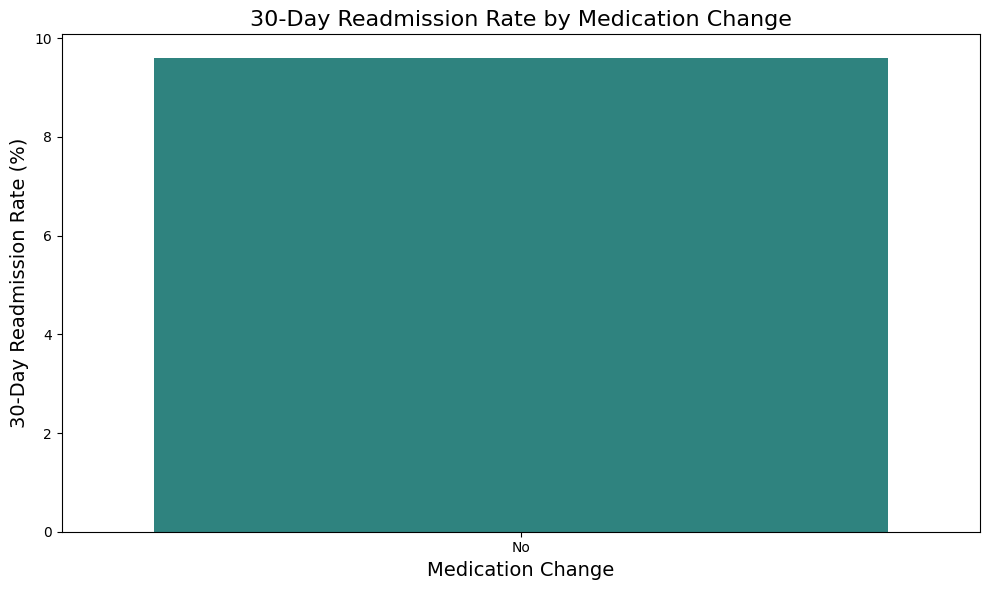

Readmission rates by change:
                       <30_days_rate
change_reconstructed               
No                              9.6
Number of rows in data: 85789
Value counts of change_reconstructed: change_reconstructed
No    85789
Name: count, dtype: int64
Value counts of readmitted: readmitted
0.0    58713
1.0     6233
Name: count, dtype: int64


In [725]:
# Identify one-hot encoded columns for change
change_cols = [col for col in data.columns if col.startswith('change_')]

# Convert standardized values back to binary (0 or 1) using a threshold
binary_data = data[change_cols].apply(lambda x: (x > 0).astype(int))
data['change_reconstructed'] = binary_data.idxmax(axis=1).str.replace('change_', '')

# Calculate readmission rate (assuming the same function as before)
def calculate_readmission_rate(df, group_col):
    grouped = df.groupby(group_col)
    readmission_rates = pd.DataFrame({
        '<30_days_rate': (grouped['readmitted'].mean() * 100).round(2)
    })
    return readmission_rates

# Calculate readmission rate for change categories
change_readmission = calculate_readmission_rate(data, 'change_reconstructed')
change_readmission = change_readmission.sort_values('<30_days_rate', ascending=False)

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=change_readmission.index, y=change_readmission['<30_days_rate'],
            hue=change_readmission.index, palette='viridis', legend=False)
plt.title('30-Day Readmission Rate by Medication Change', fontsize=16)
plt.xlabel('Medication Change', fontsize=14)
plt.ylabel('30-Day Readmission Rate (%)', fontsize=14)
plt.tight_layout()
plt.show()

# Debug output
print("Readmission rates by change:\n", change_readmission)
print("Number of rows in data:", len(data))
print("Value counts of change_reconstructed:", data['change_reconstructed'].value_counts())
print("Value counts of readmitted:", data['readmitted'].value_counts())

### Seeing the effect of insulin on readmission

Insulin columns found: ['insulin_No', 'insulin_Steady', 'insulin_Up']
Value counts of insulin_reconstructed: insulin_reconstructed
No        38964
Steady    20223
Up         5759
Name: count, dtype: int64
Sample of insulin_reconstructed:
 1        Up
3    Steady
4        No
6    Steady
7    Steady
Name: insulin_reconstructed, dtype: object


<ipython-input-726-0f802d9554da>:10: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  data['insulin_reconstructed'] = data[insulin_cols].idxmax(axis=1).str.replace('insulin_', '')


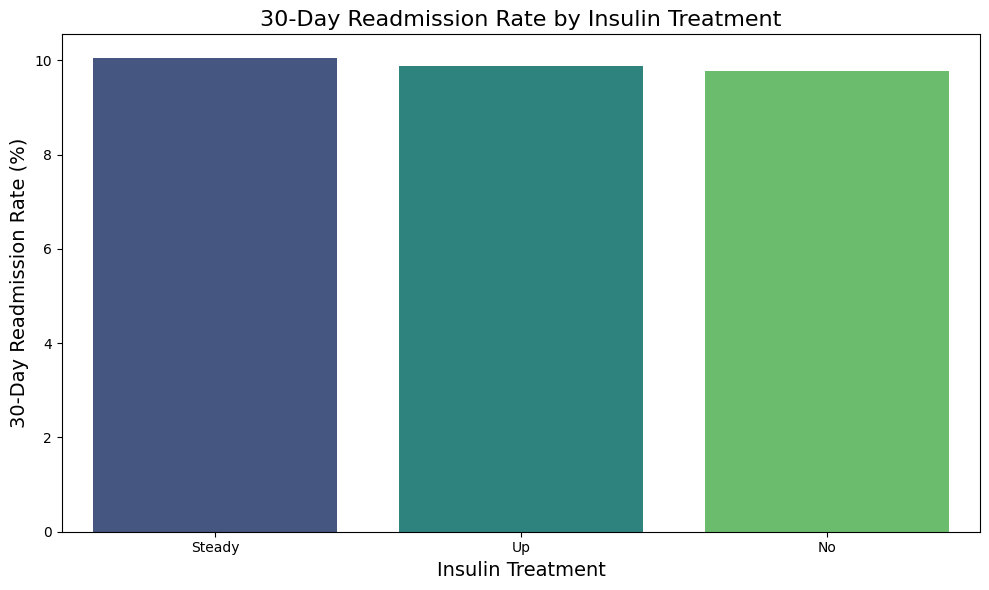

Readmission rates by insulin:
                        <30_days_rate
insulin_reconstructed               
Steady                         10.05
Up                              9.89
No                              9.77
Number of rows in data: 85789
Value counts of insulin_reconstructed: insulin_reconstructed
No        38964
Steady    20223
Up         5759
Name: count, dtype: int64
Value counts of readmitted: readmitted
0.0    58713
1.0     6233
Name: count, dtype: int64


In [726]:
# Identify one-hot encoded columns for insulin
insulin_cols = [col for col in data.columns if col.startswith('insulin_')]

# Debug: Check insulin_cols
print("Insulin columns found:", insulin_cols)
if not insulin_cols:
    raise ValueError("No insulin-related columns found. Verify 'insulin' was included in preprocessing.")

# Reconstruct insulin
data['insulin_reconstructed'] = data[insulin_cols].idxmax(axis=1).str.replace('insulin_', '')
print("Value counts of insulin_reconstructed:", data['insulin_reconstructed'].value_counts())
print("Sample of insulin_reconstructed:\n", data['insulin_reconstructed'].head())

# Calculate readmission rate
def calculate_readmission_rate(df, group_col):
    grouped = df.groupby(group_col)
    readmission_rates = pd.DataFrame({
        '<30_days_rate': (grouped['readmitted'].mean() * 100).round(2)
    })
    return readmission_rates

# Calculate readmission rate for insulin categories
insulin_readmission = calculate_readmission_rate(data, 'insulin_reconstructed')
insulin_readmission = insulin_readmission.sort_values('<30_days_rate', ascending=False)

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=insulin_readmission.index, y=insulin_readmission['<30_days_rate'],
            hue=insulin_readmission.index, palette='viridis', legend=False)
plt.title('30-Day Readmission Rate by Insulin Treatment', fontsize=16)
plt.xlabel('Insulin Treatment', fontsize=14)
plt.ylabel('30-Day Readmission Rate (%)', fontsize=14)
plt.tight_layout()
plt.show()

#output
print("Readmission rates by insulin:\n", insulin_readmission)
print("Number of rows in data:", len(data))
print("Value counts of insulin_reconstructed:", data['insulin_reconstructed'].value_counts())
print("Value counts of readmitted:", data['readmitted'].value_counts())

### Seeing the effect of specific medication on readmission

Unique values for metformin: ['No' 'Steady' 'Up' 'Down']
Unique values for repaglinide: ['No' 'Up' 'Steady' 'Down']
Unique values for nateglinide: ['No' 'Steady' 'Down' 'Up']
Unique values for chlorpropamide: ['No' 'Steady' 'Down' 'Up']
Unique values for glimepiride: ['No' 'Steady' 'Down' 'Up']
Unique values for acetohexamide: ['No' 'Steady']
Unique values for glipizide: ['No' 'Steady' 'Up' 'Down']
Unique values for glyburide: ['No' 'Steady' 'Up' 'Down']
Unique values for tolbutamide: ['No' 'Steady']
Unique values for pioglitazone: ['No' 'Steady' 'Up' 'Down']
Unique values for rosiglitazone: ['No' 'Steady' 'Up' 'Down']
Unique values for acarbose: ['No' 'Steady' 'Up' 'Down']
Unique values for miglitol: ['No' 'Steady' 'Down' 'Up']
Unique values for troglitazone: ['No' 'Steady']
Unique values for tolazamide: ['No' 'Steady' 'Up']
Unique values for examide: ['No']
Unique values for citoglipton: ['No']
Unique values for glyburide-metformin: ['No' 'Steady' 'Down' 'Up']
Unique values for glipi

<ipython-input-727-d06f5d762a7b>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Medication', y='Readmission_Rate', data=med_rates_df, palette='viridis')


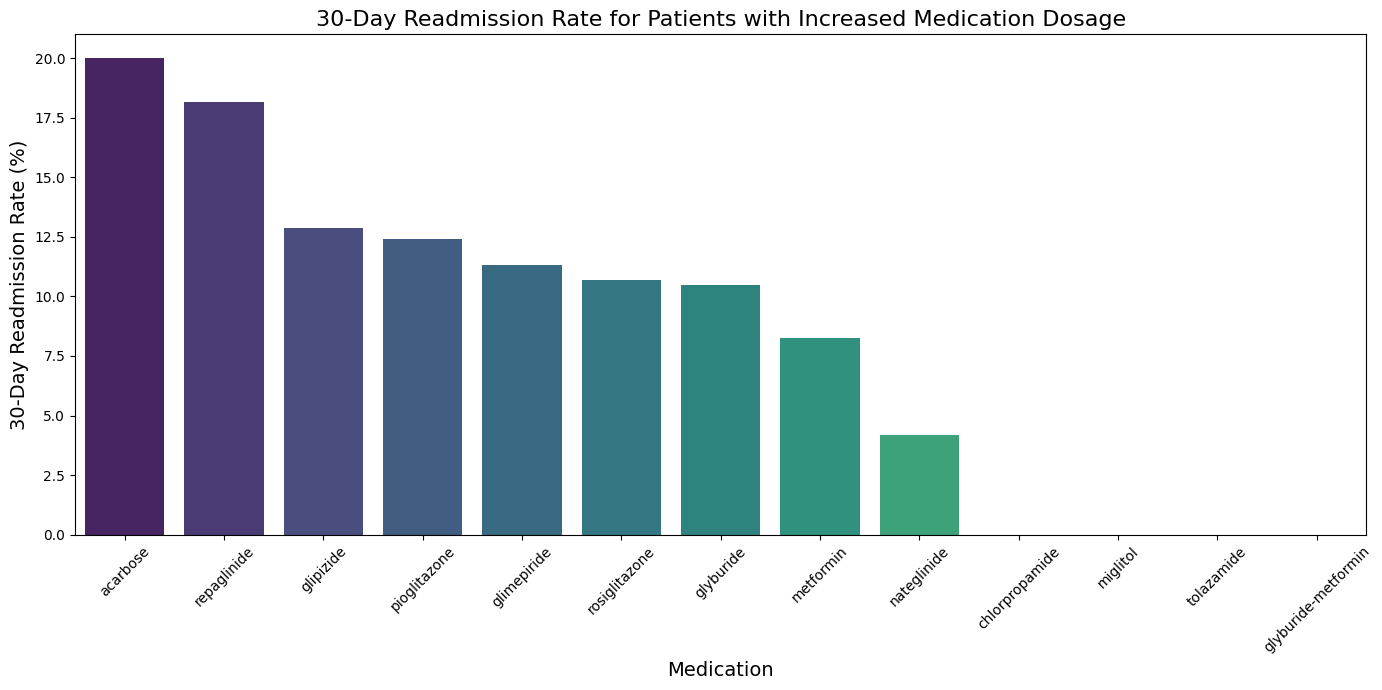


Medication readmission rates:
             Medication  Readmission_Rate
9              acarbose             20.00
1           repaglinide             18.18
5             glipizide             12.86
7          pioglitazone             12.39
4           glimepiride             11.31
8         rosiglitazone             10.67
6             glyburide             10.47
0             metformin              8.25
2           nateglinide              4.17
3        chlorpropamide              0.00
10             miglitol              0.00
11           tolazamide              0.00
12  glyburide-metformin              0.00

Medication data sample:
  metformin repaglinide nateglinide chlorpropamide glimepiride acetohexamide  \
0        No          No          No             No          No            No   
1        No          No          No             No          No            No   
2        No          No          No             No          No            No   
3        No          No          No 

In [727]:
for med in medication_cols:
    print(f"Unique values for {med}: {med_data[med].unique()}")

# After all preprocessing is done, analyze medication readmission rates
print("\nAnalyzing medication readmission rates...")
med_readmission_rates = {}
for med in medication_cols:
    med_up_data = med_data[med_data[med] == 'Up']
    if len(med_up_data) > 0:
        med_readmission_rates[med] = (med_up_data['readmitted'].mean() * 100).round(2)
        print(f"{med}: {len(med_up_data)} patients with increased dosage")

# Creating a DataFrame for easier plotting
if med_readmission_rates:
    med_rates_df = pd.DataFrame(list(med_readmission_rates.items()), columns=['Medication', 'Readmission_Rate'])
    med_rates_df = med_rates_df.sort_values('Readmission_Rate', ascending=False)

    plt.figure(figsize=(14, 7))
    sns.barplot(x='Medication', y='Readmission_Rate', data=med_rates_df, palette='viridis')
    plt.title('30-Day Readmission Rate for Patients with Increased Medication Dosage', fontsize=16)
    plt.xlabel('Medication', fontsize=14)
    plt.ylabel('30-Day Readmission Rate (%)', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\nMedication readmission rates:")
    print(med_rates_df)
else:
    print("No medications found with increased dosage")

# Debug information
print("\nMedication data sample:")
print(med_data.head())
print("\nUnique values in readmitted column:")
print(med_data['readmitted'].value_counts())

### Previous visists to readmitted column

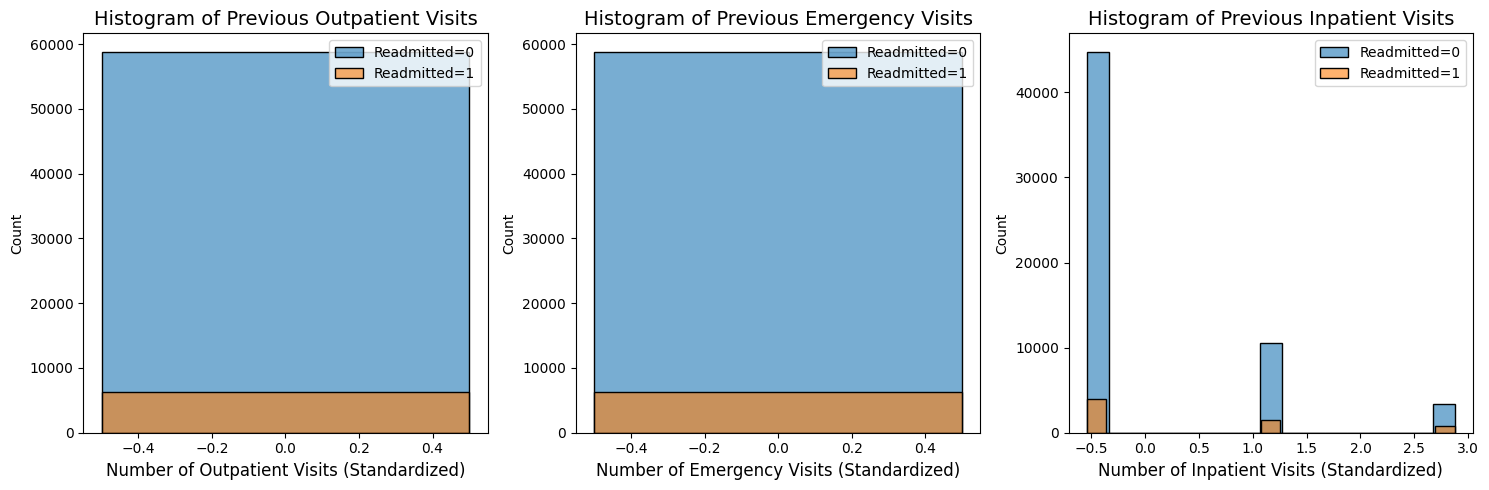

In [728]:

# Create histograms to better visualize the distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Histogram of Previous Outpatient Visits', fontsize=14)
for readmit in [0, 1]:
    sns.histplot(data[data['readmitted'] == readmit]['number_outpatient'],
                label=f'Readmitted={readmit}', alpha=0.6)
plt.xlabel('Number of Outpatient Visits (Standardized)', fontsize=12)
plt.legend()

plt.subplot(1, 3, 2)
plt.title('Histogram of Previous Emergency Visits', fontsize=14)
for readmit in [0, 1]:
    sns.histplot(data[data['readmitted'] == readmit]['number_emergency'],
                label=f'Readmitted={readmit}', alpha=0.6)
plt.xlabel('Number of Emergency Visits (Standardized)', fontsize=12)
plt.legend()

plt.subplot(1, 3, 3)
plt.title('Histogram of Previous Inpatient Visits', fontsize=14)
for readmit in [0, 1]:
    sns.histplot(data[data['readmitted'] == readmit]['number_inpatient'],
                label=f'Readmitted={readmit}', alpha=0.6)
plt.xlabel('Number of Inpatient Visits (Standardized)', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

### Seeing the relation between the payer code and readmission


Analyzing payer code readmission rates...


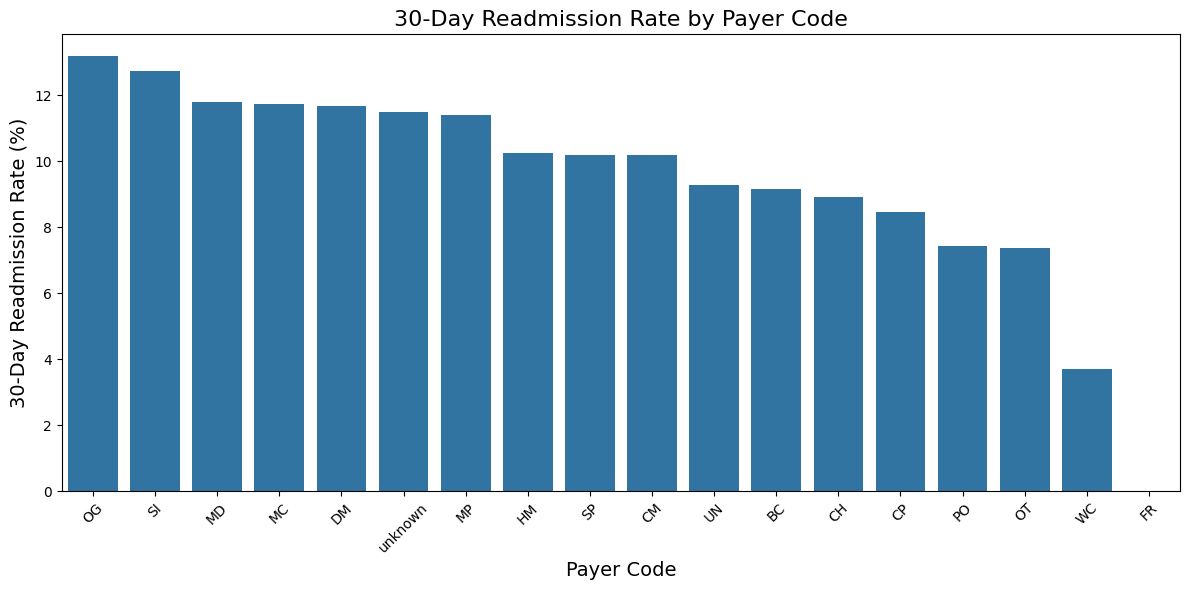


Payer code readmission rates:
payer_code
OG         13.178295
SI         12.727273
MD         11.778029
MC         11.741490
DM         11.657559
unknown    11.494596
MP         11.392405
HM         10.250279
SP         10.185740
CM         10.175620
UN          9.272876
BC          9.151450
CH          8.904110
CP          8.448480
PO          7.432432
OT          7.368421
WC          3.703704
FR          0.000000
Name: readmitted, dtype: float64

Payer code value counts:
payer_code
unknown    40245
MC         32432
HM          6273
SP          5007
BC          4655
MD          3532
CP          2533
UN          2448
CM          1936
OG          1032
PO           592
DM           549
CH           146
WC           135
OT            95
MP            79
SI            55
FR             1
Name: count, dtype: int64

Unique values in readmitted column:
readmitted
0    90393
1    11352
Name: count, dtype: int64


In [729]:
# After analyzing medications, analyze payer code readmission rates
print("\nAnalyzing payer code readmission rates...")
top_payers = payer_data['payer_code'].value_counts().nlargest(25).index

payer_readmission = payer_data[payer_data['payer_code'].isin(top_payers)]
payer_readmission_rates = payer_readmission.groupby('payer_code')['readmitted'].mean() * 100
payer_readmission_rates = payer_readmission_rates.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=payer_readmission_rates.index, y=payer_readmission_rates.values)
plt.title('30-Day Readmission Rate by Payer Code', fontsize=16)
plt.xlabel('Payer Code', fontsize=14)
plt.ylabel('30-Day Readmission Rate (%)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nPayer code readmission rates:")
print(payer_readmission_rates)

# Debug information
print("\nPayer code value counts:")
print(payer_data['payer_code'].value_counts())
print("\nUnique values in readmitted column:")
print(payer_data['readmitted'].value_counts())


### Correlation matrix

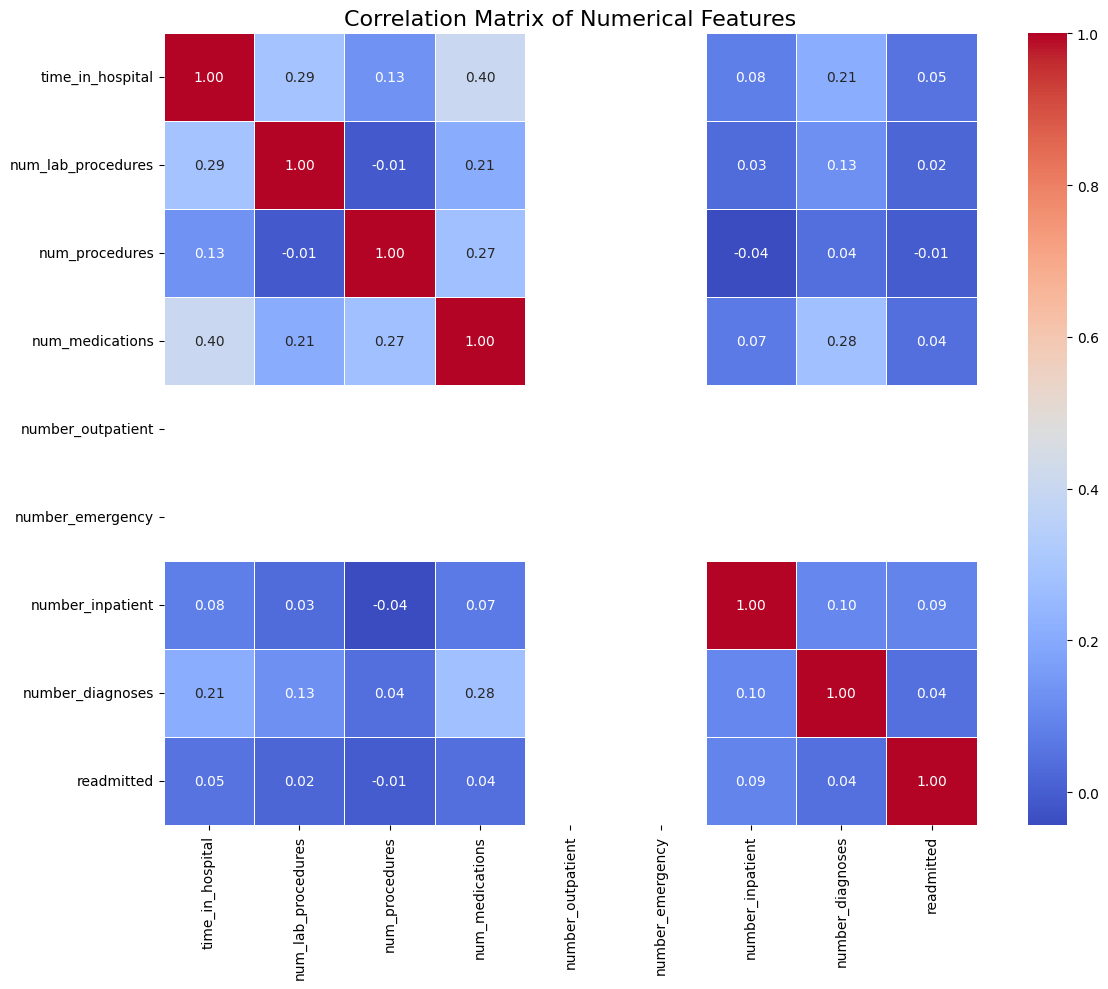

In [732]:
# Selecting numerical features
numerical_features = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses', "readmitted"]

# Creating correlation matrix
correlation_matrix = data[numerical_features].corr()

# Plot heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()